## Imports

In [1]:
# automatically reload imports as they change (for debugging cusom imports)
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import os
import sys
import datetime
import requests

# ML
import tensorflow as tf
tf.config.optimizer.set_jit(enabled=True)
!pip install -U tensorboard-plugin-profile
!pip install tensorflow-addons
import tensorflow_addons as tfa

import numpy as np
import pandas as pd


# Google Cloud Services
!pip install -q wget
import wget

# Visualization
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [4]:
# Google Drive integration
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Custom Imports
sys.path.insert(0, '/content/drive/MyDrive/GitHub/ShuffleExchange/Shuffle_AI/ModelComponents')
import datasets
import pipeline
import parameters
import losses_and_metrics
import parameters
import backbone
import transformers
import prediction_heads
import panoptic_neck
import tokenizers
import model
import learning_rate_schedulers

### Set Parameters

In [6]:
# Choose dataset
dataset_name = 'Fashionpedia'
drive_type = 'google_drive'
model_name='custom_DETR'

In [7]:
# Set Filepaths
filepaths = parameters.Filepaths(dataset_name=dataset_name, drive_type=drive_type, model_name=model_name)

# Set Model Parameters
model_parameters = parameters.ModelParameters(dataset_name=dataset_name)
params = model_parameters.default_params()

# set Mixed Precision and Distributed Training
strategy_options = parameters.StrategyOptions(mixed_precision=False)
strategy = strategy_options.strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Load Dataset

Download / Extract datasets

In [8]:
# initialize dataset handler
data_loader = datasets.Fashionpedia(**model_parameters.default_params(), 
                                    **filepaths.default_params())

# download form external source to archive and extract to local dir
# note: set force_rebuild=False to skip files already found
# note: not all images in the test set have annotations
data_loader.get_data(download=True, unzip=True, force_rebuild=False)

/content/drive/MyDrive/datasets/Fashionpedia/images/train/train2020.zip found. Using previously extracted data. (Note: set force_rebuild=True to override)
/content/drive/MyDrive/datasets/Fashionpedia/annotations/train/instances_attributes_train2020.json found. Using previously extracted data. (Note: set force_rebuild=True to override)
/content/drive/MyDrive/datasets/Fashionpedia/images/test/val_test2020.zip found. Using previously extracted data. (Note: set force_rebuild=True to override)
/content/drive/MyDrive/datasets/Fashionpedia/annotations/test/instances_attributes_val2020.json found. Using previously extracted data. (Note: set force_rebuild=True to override)
/content/drive/MyDrive/datasets/Fashionpedia/images/train/train2020.zip
/content/drive/MyDrive/datasets/Fashionpedia/images/test/val_test2020.zip


In [9]:
# get dataframes
df_valid = data_loader.dataframes(subset='val', force_rebuild=False)
df_train = data_loader.dataframes(subset='train', force_rebuild=False)

/content/drive/MyDrive/datasets/Fashionpedia/annotations/test/test_full_annotations_df.json found. Using previously extracted data. (Note: set force_rebuild=True to override)
Previously prepared datafile found. Loading from saved file.
Use "force_rebuild=True" to generate dataframe from scratch
/content/drive/MyDrive/datasets/Fashionpedia/annotations/train/train_full_annotations_df.json found. Using previously extracted data. (Note: set force_rebuild=True to override)
Previously prepared datafile found. Loading from saved file.
Use "force_rebuild=True" to generate dataframe from scratch


In [10]:
df_train.head(1)

,id_num,file_name,bbox,category,attribute,segmentation,image_width,image_height,num_boxes,image_path
0,16145,6ce91b2c047f7f441edd5dc17326ae17.jpg,"[[0.2568359375, 0.76953125, 0.1376953125, 0.19...","[[shoe], [shoe], [shorts]]","[[<PAD>], [<PAD>], [no special manufacturing t...","[[[385, 886, 385, 906, 396, 931, 400, 947, 401...",1024,1024,3,/content/datasets/Fashionpedia/images/train/tr...


## Create TF Dataset

In [11]:
# initialize helper classes
data_pipeline = pipeline.Pipeline(**params)
tfrecords_handler = pipeline.TFRecordsConversions(**params)
image_augmentations = pipeline.Augmentations()

TF Dataset

In [12]:
# create datasets where tensors are padded to uniform num obj = max num obj in df

data_pipeline = pipeline.Pipeline(**model_parameters.default_params())

ds_train = data_pipeline.data_generator(
                             labels_df=df_train, 
                             text_pad_val=params['pad_value'],
                             cache_before_image_load=True,
                             decode_images=True,
                             stream_from_directory=False)

ds_train_augmented = image_augmentations.apply_image_augmentations(ds_train)

ds_valid = data_pipeline.data_generator(
                             labels_df=df_valid, 
                             text_pad_val=params['pad_value'],
                             cache_before_image_load=True,
                             decode_images=True,
                             stream_from_directory=False)

{'image_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'category': TensorSpec(shape=(74, 1), dtype=tf.string, name=None), 'attribute': TensorSpec(shape=(74, 14), dtype=tf.string, name=None), 'bbox': TensorSpec(shape=(74, 4), dtype=tf.float32, name=None), 'num_objects': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image': TensorSpec(shape=(560, 560, 3), dtype=tf.float32, name=None)} 

{'image_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'category': TensorSpec(shape=(27, 1), dtype=tf.string, name=None), 'attribute': TensorSpec(shape=(27, 13), dtype=tf.string, name=None), 'bbox': TensorSpec(shape=(27, 4), dtype=tf.float32, name=None), 'num_objects': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image': TensorSpec(shape=(560, 560, 3), dtype=tf.float32, name=None)} 



In [13]:
for val in ds_train_augmented.take(1):
    print(val.keys())

dict_keys(['image_id', 'category', 'attribute', 'bbox', 'num_objects', 'image'])


Visualize the dataset

In [14]:
def show_example(val, verbose=False):

    image_id = val['image_id'].numpy()
    num_obj = val['num_objects'].numpy()
    image = val['image']
    bbox = val['bbox'][:num_obj, ...]
    category = val['category'][:num_obj, ...]
    attribute = val['attribute'][:num_obj, ...]


    if verbose:
        print('image_id:', image_id, 'num_obj:', num_obj)
        print('image:', image.shape, 'bbox:', bbox.shape, 
              'category:', category.shape, 'attribute:', attribute.shape)

    
    # display image
    fig = plt.figure()
    currentAxis = plt.gca()
    imgplot = plt.imshow(image)

    # get image data
    image_height = image.shape[-3]
    image_width = image.shape[-2]
    boxes = bbox.numpy().tolist()
    categories = category.numpy().tolist()
    attributes = attribute.numpy().tolist()

    # add boxes to image
    for i in range(len(boxes)):
        category = categories[i]
        attribute = attributes[i]
        box = boxes[i]

        # report info
        print(f'box {i}', 'category:', category)
        print('attribute:', attribute)

        # update box values for matplotlib
        ymin, xmin, ymax, xmax = box
        xmin = xmin * image_width
        xmax = xmax * image_width
        ymin = ymin * image_height
        ymax = ymax * image_height

        width = xmax - xmin
        height = ymax - ymin

        currentAxis.add_patch(Rectangle((xmin, ymin),width, height,
                                alpha=1, fill=False, 
                                label=category + attribute))

    plt.show()

    return plt

box 0 category: [b'neckline']
attribute: [b'asymmetric (neckline)', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>']
box 1 category: [b'sleeve']
attribute: [b'wrist-length', b'set-in sleeve', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>']
box 2 category: [b'top, t-shirt, sweatshirt']
attribute: [b'no special manufacturing technique', b'plain (pattern)', b'normal waist', b'no non-textile material', b'regular (fit)', b'classic (t-shirt)', b'hip (length)', b'symmetrical', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>']
box 3 category: [b'zipper']
attribute: [b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>']
box 4 category: [b'sleeve']
attribute: [b'wrist-length', b'set-in sleeve', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>', b'<PAD>

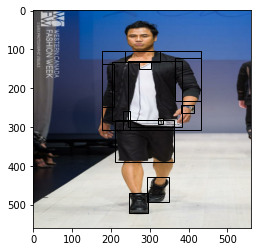

In [15]:
# training image
for val in ds_train.take(1):
    show_example(val)

In [ ]:
# augmented training image
for val in ds_train_augmented.take(1):
    show_example(val)

In [ ]:
# validation image
for val in ds_valid.take(1):
    show_example(val)

## Model

Initialize & Compile

In [22]:
load_weights = True

# initialize
with strategy.scope():
    clothing_model = model.ClothingPredictor(**params)

    # build
    for val in ds_train_augmented.batch(1).take(1): 
        temp_out = clothing_model(val)

    # Compiler components
    lr = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate=.001, 
                                                           first_decay_steps=4000)

    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=.0001)  # optimizer used in DETR paper
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    # load saved weights
    if load_weights:
        clothing_model.load_weights(filepaths.default_params('checkpoint_dir'))

    # compile. (note: Losses and Metrics are built directly into model)
    clothing_model.compile(optimizer=optimizer)

# show summary
clothing_model.summary()

Model: "ClothingPredictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Tokenization (Tokenization)  multiple                  0 (unused)
_________________________________________________________________
Tokenization (InverseTokeniz multiple                  0         
_________________________________________________________________
EncoderBackbone (EncoderBack multiple                  7768569   
_________________________________________________________________
BackboneNeck (BackboneNeck)  multiple                  361728    
_________________________________________________________________
ImageEncoderAttention (Image multiple                  1666048   
_________________________________________________________________
DecoderPrep (DecoderPrep)    multiple                  24576     
_________________________________________________________________
DecoderBlock_0 (DecoderBlock multiple            

Test Training Loop

In [23]:
# test the training loop
for val in ds_train.batch(2).take(1):
    temp_inp = val
    temp_train_out = clothing_model.train_step(val, apply_grads=False)
temp_train_out

{'Attribute_Loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.138017>,
 'Box_Loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.9641356>,
 'Category_Loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7549863>,
 'Existence_Loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.4835273e-08>,
 'IOU': <tf.Tensor: shape=(), dtype=float32, numpy=0.73881376>,
 'Loss': <tf.Tensor: shape=(), dtype=float32, numpy=14.85714>,
 'mAP_50': <tf.Tensor: shape=(), dtype=float32, numpy=0.083333336>,
 'mAP_50_95': <tf.Tensor: shape=(), dtype=float32, numpy=0.05625>}

## Training

In [24]:
# Callbacks
nan_stop = tf.keras.callbacks.TerminateOnNaN()
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepaths.default_params('checkpoint_dir'),
                                                save_weights_only=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir logs/fit

Train Model

In [25]:
# training
# NOTE: Training takes time to build initial graph, then proceeds quickly
# NOTE: Training does not work on TPU because of bipartite matching function
# NOTE: Training does not work on CPU (unkown why, throws error related to Conv gradients)

USE_AUGMENTATIONS = True
NUM_EPOCHS = 1
BATCH_SIZE = 16  # use <= 16 on Colab GPU

if USE_AUGMENTATIONS:
    ds = ds_train_augmented.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
else:
    ds = ds_train.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

validation_data = ds_valid.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

# train
clothing_model.fit(ds, epochs=NUM_EPOCHS, validation_data=validation_data,
                   callbacks=[nan_stop, checkpoint, tensorboard])

2851/2851 [==============================] - 956s 295ms/step - Loss: 15.1859 - Category_Loss: 5.8389 - Attribute_Loss: 2.6694 - Box_Loss: 6.6776 - Existence_Loss: 3.6298e-08 - IOU: 0.6706 - mAP_50: 0.1104 - mAP_50_95: 0.0697 - val_Loss: 14.4734 - val_Category_Loss: 5.3022 - val_Attribute_Loss: 2.7308 - val_Box_Loss: 6.4405 - val_Existence_Loss: 3.7736e-08 - val_IOU: 0.6590 - val_mAP_50: 0.1120 - val_mAP_50_95: 0.0697


In [ ]:
def show_prediction(val, model):

    print('True Values:')
    print('image_id:', val['image_id'].shape)
    print('image:', val['image'].shape, 'bbox:', val['bbox'].shape, 
          'category:', val['category'].shape, 'attribute:', val['attribute'].shape) 
    
    category, attribute, box_coord_preds = model(val)

    # update values
    val['image_id'] = val['image_id'][0, ...]
    val['image'] = val['image'][0, ...]
    val['bbox'] = box_coord_preds[0, ...]
    val['category'] = category[0, ...]
    val['attribute'] = attribute[0, ...]
    val['num_objects'] = tf.constant(10)
    print(val['num_objects'])

    outs = show_example(val, verbose=True)
    return outs

In [ ]:
for val in ds_valid.batch(1).take(1):
    show_prediction(val, clothing_model)